> # Long sequence

Train with long sequence can have long time and be unstable. And model can forget some steps at first.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

- Unstable gradient

We can use some methods in RNN that we used to solve gradient problem in DNN. But activaiton function that doesn't converge is not a good idea. Output and gradient can explode. So we can use tanh activation function. And gradient clipping also can be good solution to prevent gradient exploding.

RNN can't effectively use batch normalization method. We can use it by adding batch normalization layer atmemory cell. But it doesn't make better score. Another method that fit better is layer normalization. This normalize about feature dimension. One advantage is that it can independently calculate statistics of each time step. This means it operates same both train and test. Layer noramlization train one scale and moving parameter at each input. It is used after linear combination of input and hidden states.

To use it in RNN, we have to define user memory cell.

In [2]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwarg):
        super().__init__(**kwarg)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = keras.layers.LayerNormalization()
        self.activation = keras.activations.get(activation)
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [3]:
model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

- Short-term memory problem(LSTM)

Some information disappears after each step. Through some long time, the RNN model doesn't have memory of first input. So we can use **LSTM** cell like simple RNN cell. But performance will increase. Train will converge faster and detect long-term dependence. 

In [4]:
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

We can also write above code like under code. But LSTM layer is widely used because it uses optimized realization.

In [5]:
model = keras.models.Sequential([
    keras.layers.RNN(keras.layers.LSTMCell(20), return_sequences=True, input_shape=[None, 1]),
    keras.layers.RNN(keras.layers.LSTMCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

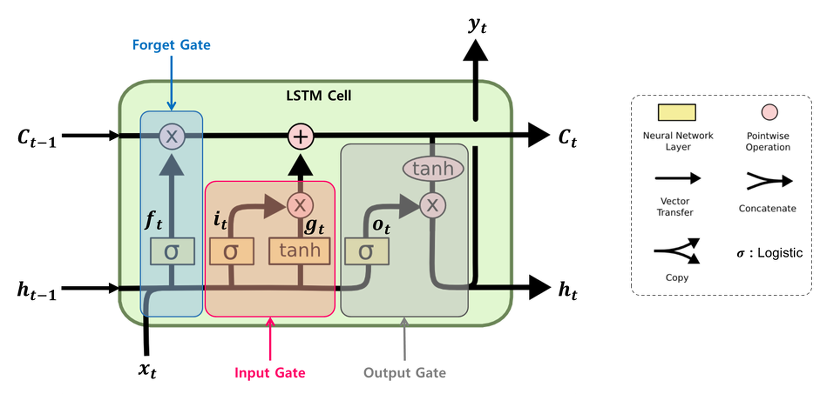

There are additional $\mathbf{c}_t, \ \mathbf{h}_t$ two vectors. $\mathbf{c}_t$ is long-term memory and $\mathbf{h}_t$ is short-term memory.

Main idea is network saves long-term state, throw away and learn things to read. $\mathbf{c}_{t-1}$ passes network left to right, losses some memory through forget gate, theb adds part of new memory by sum operation. $\mathbf{c}_t$ is sent to output without additional conversion. So some memory is deleted and added. Then after sum opration, the long-term state is copied and sent to tanh function. This result is filtered by output gate. It makes short state $\mathbf{h}_t$.

Current input vector $\mathbf{x}_t$ and previous $\mathbf{c}_{t-1}$ are injected to 4 different fully connected layer. These layers have all different purpose. Main layer is that prints $\mathbf{g}_t$. This layer analyzes $\mathbf{x}_t$ and $\mathbf{c}_{t-1}$. In LSTM, the most important part of this ouput is stored in long-term state. Other 3 layers are gate controller. Since they use logistic activation function, output value of them are between 0 and 1. The outputs injected by multiplication operator. It closes gate if 0 is output value, and opens gate if 1 is output value. Forget gate(controled by $\mathbf{f}_t$) controls part of long-term state to forget. Input gate(controled by $\mathbf{i}_t$) controls part of $\mathbf{g}_t$ added to long-state. Output gate(controled by $\mathbf{o}_t$) what part of long-term state to read and print this time step's $\mathbf{h}_t$ and $\mathbf{y}_t$.

$\quad \mathbf{i}_t = \sigma({\mathbf{W}_{xi}}^T\mathbf{x}_t \ + \ {\mathbf{W}_{hi}}^T\mathbf{h}_{t-1} \ + \ \mathbf{b}_i)$

$\quad \mathbf{f}_t = \sigma({\mathbf{W}_{xf}}^T\mathbf{x}_t \ + \ {\mathbf{W}_{hf}}^T\mathbf{h}_{t-1} \ + \ \mathbf{b}_f)$

$\quad \mathbf{f}_t = \sigma({\mathbf{W}_{xo}}^T\mathbf{x}_t \ + \ {\mathbf{W}_{ho}}^T\mathbf{h}_{t-1} \ + \ \mathbf{b}_o)$

$\quad \mathbf{g}_t = \tanh({\mathbf{W}_{xg}}^T\mathbf{x}_t \ + \ {\mathbf{W}_{hg}}^T\mathbf{h}_{t-1} \ + \ \mathbf{b}_g)$

$\quad \mathbf{c}_t = \mathbf{f}_t \otimes \mathbf{c}_{t-1}+\mathbf{i}_t \otimes \mathbf{g}_t $

$\quad \mathbf{y}_t = \mathbf{h}_t =\mathbf{o}_t\ \otimes \tanh(\mathbf{c}_t)$

In general **LSTM** cell, gate controler can see input $\mathbf{x}_t$ and previous short-term state $\mathbf{h}_{t-1}$. If gate controler is exposed by long-term state, we can get better score. So variant of LSTM, peephole connection, is realized. $\mathbf{c}_{t-1}$ is added to $\mathbf{f}_t$ and $\mathbf{i}_t$ as input. And $\mathbf{c}_t$ is added to $\mathbf{o}_t$ as input.

- GRU

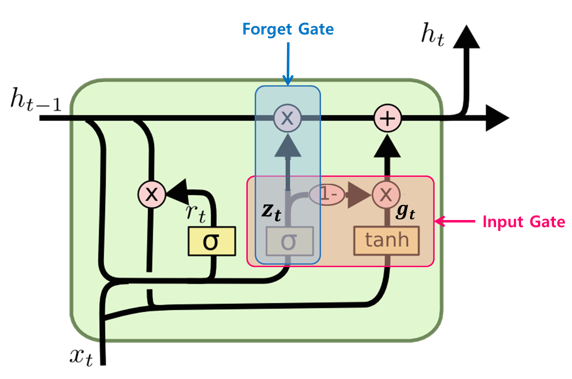

GRU cell is a simplified model of LSTM cell. Two state vector is combined as a $\mathbf{h}_t$ vector. One gate controler $\mathbf{z}_t$ controls both forget gate and input gate. If it prints 1, forget gate opened and input gate colsed. 0 is reverse. There is no output gate. All state vector is printed at each time step. But new gate controler $\mathbf{r}_t$ that controls what part of previous state exposed to main gate.

$\quad \mathbf{z}_t = \sigma({\mathbf{W}_{xz}}^T\mathbf{x}_t \ + \ {\mathbf{W}_{hz}}^T\mathbf{h}_{t-1} \ + \ \mathbf{b}_z)$

$\quad \mathbf{r}_t = \sigma({\mathbf{W}_{xr}}^T\mathbf{x}_t \ + \ {\mathbf{W}_{hr}}^T\mathbf{h}_{t-1} \ + \ \mathbf{b}_r)$

$\quad \mathbf{g}_t = \tanh({\mathbf{W}_{xg}}^T\mathbf{x}_t \ + \ {\mathbf{W}_{hg}}^T(\mathbf{r}_t \otimes \mathbf{h}_{t-1}) \ + \ \mathbf{b}_g)$

$\quad \mathbf{h}_t = \mathbf{z}_t \otimes \mathbf{h}_{t-1}+(1 - \mathbf{z}_t) \otimes \mathbf{g}_t $

keras provides **keras.layers.GRU** layer. LSTM and GRU can handle long sequence than simple RNN but they has very limited short-term memory. One method to overcome it is to use 1D convolutional layer and shorten input sequence.

Like filter sliding in CNN, we can apply it 1D sequence. Some kernels of 1D convolutional layer slides on sequence and print 1D feature map at each kernel. Each kernel train to detect a short sequence pattern. If we use 10 kernels, output of the layer is 10 1D sequence or a 10D sequence. Stride 1 and same padding makes length of ouput sequence same with input sequence. But valid padding and stride bigger than 1 makes the length shorter than input sequence. It helps the GRU layer to detect more longer pattern. It's exmaple of them.

In [6]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid", input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

- WAVENET

This network stacks 1D convultional layer that two times increases dilation rate. First layer watches 2 time steps at once. next layer watches 4 time steps and next is 8. Low level layer train short-term pattern. High level layer train long-term pattern.

In [7]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal", 
                                  activation='relu', dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))

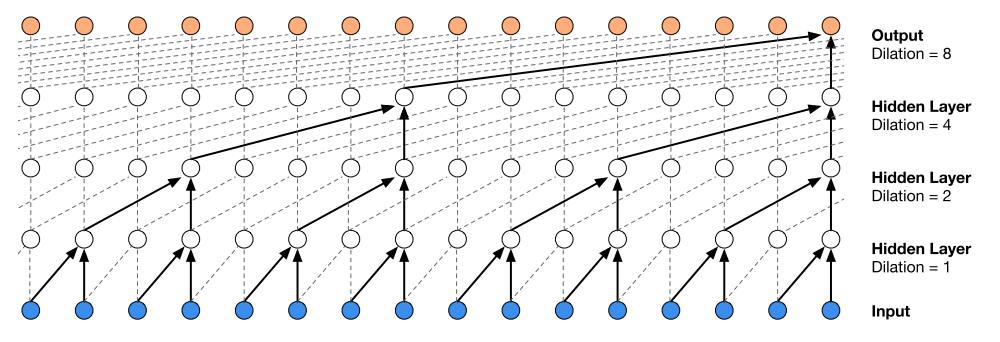